In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime as dt
import math

import warnings
warnings.filterwarnings('ignore')


ca_categories = pd.read_json('GB_category_id.json')

ca_videos = pd.read_csv('GBvideos.csv'
                        #,encoding='latin1'
                        
                        #, cyrillic encoding='latin1'
                       )


In [2]:
ca_videos['trending_date'].sort_values()
print('Data collection start date: ', ca_videos['trending_date'].min())
print('Date collection end date: ', ca_videos['trending_date'].max())

Data collection start date:  17.01.12
Date collection end date:  18.31.05


### Publication Date

In [3]:
ca_videos['publish_time'] = pd.to_datetime(ca_videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.date
print('Original publication start date: ', ca_videos['publish_time'].min())
print('Original publication end date: ', ca_videos['trending_date'].max())

Original publication start date:  2007-03-05
Original publication end date:  18.31.05


## Categories

In [4]:
categories = {int(category['id']): category['snippet']['title'] for category in ca_categories['items']}
ca_videos["category_name"] = ca_videos["category_id"].map(categories)
categories

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In the description above, we determined that #24 is the category with the most trending videos. Here we can see that it's entertainment.

## Boolean Data

Now we evaluate the boolean data, before moving on to the numerical data. 
There are three boolean variables: comment_disabled, ratings_disabled, and video_error_or_removed.

In [5]:
bool_data = ca_videos.select_dtypes(include = 'bool').apply(pd.Series.value_counts)
print(bool_data)
print()
print('Number of videos with comments and ratings disabled that have been removed: ', 
      len(ca_videos[(ca_videos["comments_disabled"] == True) & (ca_videos["ratings_disabled"] == True) & (ca_videos['video_error_or_removed'] == True)]))
print('Number of videos with both comments and ratings disabled: ',  
      len(ca_videos[(ca_videos["comments_disabled"] == True) & (ca_videos["ratings_disabled"] == True)]))

       comments_disabled  ratings_disabled  video_error_or_removed
False              38233             38644                   38847
True                 683               272                      69

Number of videos with comments and ratings disabled that have been removed:  0
Number of videos with both comments and ratings disabled:  224


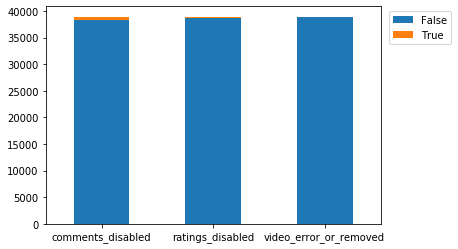

In [6]:
bool_data = bool_data.transpose()
bool_data.plot.bar(stacked = True)
plt.xticks(rotation = 'horizontal')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

Clearly a very low percentage of videos have disabled comments, ratings, or have been removed due to error. 

In [7]:
ca_videos.loc[ca_videos['video_error_or_removed'] == True].head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
31995,BEePFpC9qG8,18.04.05,360 Google Doodles/Spotlight Stories: Back to ...,Google Spotlight Stories,1,2018-05-02,"google spotlight stories|""spotlight stories""|""...",2465294,99973,17299,16813,https://i.ytimg.com/vi/BEePFpC9qG8/default.jpg,False,False,True,"The Google Doodle, Google Spotlight Stories, G...",Film & Animation
32169,BEePFpC9qG8,18.05.05,360 Google Doodles/Spotlight Stories: Back to ...,Google Spotlight Stories,1,2018-05-02,"google spotlight stories|""spotlight stories""|""...",2033836,121001,1702,16464,https://i.ytimg.com/vi/BEePFpC9qG8/default.jpg,False,False,True,"The Google Doodle, Google Spotlight Stories, G...",Film & Animation
32173,1Aoc-cd9eYs,18.05.05,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",2260075,199123,3437,13416,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,Entertainment
32337,BEePFpC9qG8,18.06.05,360 Google Doodles/Spotlight Stories: Back to ...,Google Spotlight Stories,1,2018-05-02,"google spotlight stories|""spotlight stories""|""...",6937924,241122,11515,15101,https://i.ytimg.com/vi/BEePFpC9qG8/default.jpg,False,False,True,"The Google Doodle, Google Spotlight Stories, G...",Film & Animation
32341,1Aoc-cd9eYs,18.06.05,Cobra Kai Ep 2 - Strike First - The Karate Kid...,Cobra Kai,24,2018-05-02,"Cobra Kai|""Karate Kid""|""YouTube Red Original S...",75626,3529,65,328,https://i.ytimg.com/vi/1Aoc-cd9eYs/default.jpg,False,False,True,Present day Daniel LaRusso lives a charmed lif...,Entertainment


While, videos with comments_disabled and ratings_disabled might give us some insight, videos that were removed and/or had an error can be dropped. We can see that some of them have titles such as 'deleted videos' and or other missing values. Given the small number of deleted videos, the dataset will not be majorily influenced by removing the entries with deleted videos and the variables video_error_or_removed.

In [8]:
#delete rows and columns
ca_videos = ca_videos[~ca_videos.video_error_or_removed]
del ca_videos['video_error_or_removed']

## Numerical Data Exploration

In [9]:
ca_videos.describe(include = [np.number])

,category_id,views,likes,dislikes,comment_count
count,38847.000000,3.884700e+04,3.884700e+04,3.884700e+04,3.884700e+04
mean,16.830231,5.904088e+06,1.343947e+05,7.587944e+03,1.308051e+04
std,7.749929,1.900500e+07,3.500617e+05,5.096867e+04,5.069698e+04
min,1.000000,8.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,10.000000,2.510330e+05,5.881500e+03,2.000000e+02,6.780000e+02
50%,20.000000,9.779410e+05,2.513000e+04,8.190000e+02,2.474000e+03
75%,24.000000,3.680534e+06,1.140355e+05,3.356000e+03,9.237000e+03
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


We can see that most data points in likes, dislikes, and comment_count are fairly close to the mean. However, the views data points seem to be more spread out. It's possible that there are outliers where videos become trending with fewer/more views, likes, or comment counts. It's also possible for videos with disabled comments and/or ratings to make it to the trending list. 

We can also see that the number of views can be as low as 733 and as high as 137, 843, 100. 

Let's visualize their distribution to get a better idea.

### Views Distribution

In [10]:
print('Skewness: ', ca_videos['views'].skew())
print('Kurtosis: ', ca_videos['views'].kurtosis())
ca_videos['views'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  9.069645383650133
Kurtosis:  115.53694634421694


count    3.884700e+04
mean     5.904088e+06
std      1.900500e+07
min      8.510000e+02
15%      1.252558e+05
30%      3.356122e+05
50%      9.779410e+05
65%      2.116632e+06
80%      5.221907e+06
95%      2.440834e+07
max      4.245389e+08
Name: views, dtype: float64

We can also see that the number of views can be as low as 733 and as high as 137, 843, 100. 

50% of videos have 176,707 views or less and the majority of videos (95%) have 4,090,188. However, we can see that 80% of videos have around 1 million views or less, which means that only 15% of the 95% have views between 2 and 4 million.

We can clearly see that the data are fairly spread out, especially as the skewness and kurtosis are very high,

To put these numbers in perspective and to minimize the visibility of outliers, let's visualize the distribution of videos with less than 4,500,000 views.

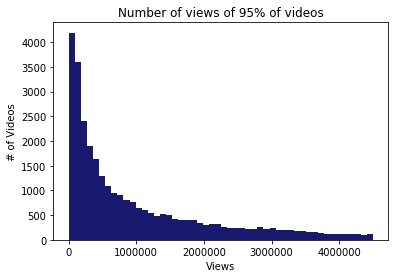

In [11]:
ax = sns.distplot(ca_videos[ca_videos["views"] < 4.5e6]["views"], kde = False, color = 'midnightblue', 
                  hist_kws = {'alpha': 1})
ax.set(xlabel = 'Views', ylabel = '# of Videos')
ax.set(title = "Number of views of 95% of videos")
plt.show()

### Likes Distribution

In [12]:
print('Skewness: ', ca_videos['likes'].skew())
print('Kurtosis: ', ca_videos['likes'].kurtosis())
ca_videos['likes'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  6.871288097742075
Kurtosis:  66.53476291220764


count    3.884700e+04
mean     1.343947e+05
std      3.500617e+05
min      0.000000e+00
15%      2.719800e+03
30%      8.139000e+03
50%      2.513000e+04
65%      6.103260e+04
80%      1.579006e+05
95%      5.622580e+05
max      5.613827e+06
Name: likes, dtype: float64

Here we can see that the minimum number of likes is 0 but that is likely because some videos have that feature disables. The max can reach as high as 5,053,338. 

95% of videos 165,236 likes or less, while 80% have 38,557 likes. This shows us that the majority of videos do not require a huge amount of likes to become trending. 

We will visualize the spread of videos with 200,000 likes or less. 

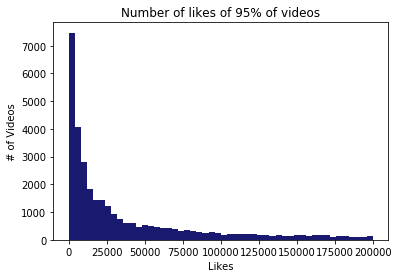

In [13]:
ax = sns.distplot(ca_videos[ca_videos["likes"] < 2e5]["likes"], kde = False, color = 'midnightblue', 
                  hist_kws = {'alpha': 1})
ax.set(xlabel = 'Likes', ylabel = '# of Videos')
ax.set(title = "Number of likes of 95% of videos")
plt.show()

### Dislikes Distribution

In [14]:
print('Skewness: ', ca_videos['dislikes'].skew())
print('Kurtosis: ', ca_videos['dislikes'].kurtosis())
ca_videos['dislikes'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  27.04532607607513
Kurtosis:  876.0672892522236


count    3.884700e+04
mean     7.587944e+03
std      5.096867e+04
min      0.000000e+00
15%      9.700000e+01
30%      2.750000e+02
50%      8.190000e+02
65%      1.862000e+03
80%      5.090000e+03
95%      2.686480e+04
max      1.944971e+06
Name: dislikes, dtype: float64

The minimum number of dislikes can be as low as 0 and as high as 1,602,383. The majority, however, have fewer than 6,468 dislikes. So only 5% if videos are between 6,000-1,000,000. Again 80% of videos have 1,288 ldislikes or less. So, it's less common to have dislikes on trending videos. 

Now we will visualize the distribution of videos with less than 6000 dislikes

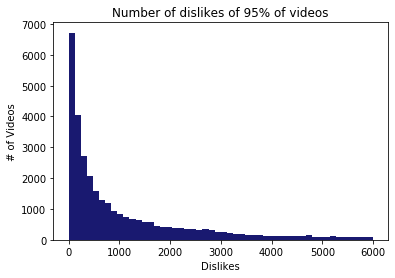

In [15]:
ax = sns.distplot(ca_videos[ca_videos["dislikes"] < 6e3]["dislikes"], kde = False, color = 'midnightblue', 
                  hist_kws = {'alpha': 1})
ax.set(xlabel = 'Dislikes', ylabel = '# of Videos')
ax.set(title = "Number of dislikes of 95% of videos")
plt.show()

### Comment Count Distribution

In [16]:
print('Skewness: ', ca_videos['comment_count'].skew())
print('Kurtosis: ', ca_videos['comment_count'].kurtosis())
ca_videos['comment_count'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

Skewness:  15.543603334854355
Kurtosis:  344.5430529320791


count    3.884700e+04
mean     1.308051e+04
std      5.069698e+04
min      0.000000e+00
15%      3.420000e+02
30%      9.080000e+02
50%      2.474000e+03
65%      5.158000e+03
80%      1.252800e+04
95%      5.023130e+04
max      1.626501e+06
Name: comment_count, dtype: float64

Comment count can go from as low as 0 to as high as 1,114,800. The majority have a count of 19,189 comments or less, while 80% have a comment count of 4,823 or less. 

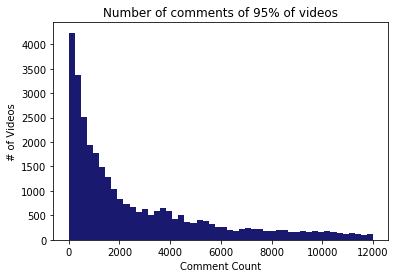

In [17]:
ax = sns.distplot(ca_videos[ca_videos["comment_count"] < 1.2e4]["comment_count"], kde = False, color = 'midnightblue',
                  hist_kws = {'alpha': 1})
         
ax.set(xlabel = 'Comment Count', ylabel = '# of Videos')
ax.set(title = "Number of comments of 95% of videos")
plt.show()

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(ca_videos.select_dtypes(include = ['number']))
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const            6.450483
category_id      1.049928
views            3.823265
likes            7.469701
dislikes         3.450295
comment_count    6.870733
dtype: float64

## Dislikes Ratio

In [19]:
ca_videos['dislikes_ratio'] = ca_videos['dislikes']/(ca_videos['likes']+ ca_videos['dislikes'])
ca_videos[ca_videos['dislikes_ratio'].apply(lambda x: pd.isna(x))]


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,category_name,dislikes_ratio
75,vHCvmZlC5jQ,17.14.11,Every Kevin Spacey Joke from Difficult People,Difficult Psycho,24,2017-11-01,"kevin spacey|""difficult people""|""julie klausne...",735972,0,0,0,https://i.ytimg.com/vi/vHCvmZlC5jQ/default.jpg,True,True,Watch Difficult People on Hulu now!! http://hu...,Entertainment,NaN
296,vHCvmZlC5jQ,17.15.11,Every Kevin Spacey Joke from Difficult People,Difficult Psycho,24,2017-11-01,"kevin spacey|""difficult people""|""julie klausne...",742287,0,0,0,https://i.ytimg.com/vi/vHCvmZlC5jQ/default.jpg,True,True,Watch Difficult People on Hulu now!! http://hu...,Entertainment,NaN
509,vHCvmZlC5jQ,17.16.11,Every Kevin Spacey Joke from Difficult People,Difficult Psycho,24,2017-11-01,"kevin spacey|""difficult people""|""julie klausne...",745369,0,0,0,https://i.ytimg.com/vi/vHCvmZlC5jQ/default.jpg,True,True,Watch Difficult People on Hulu now!! http://hu...,Entertainment,NaN
749,vHCvmZlC5jQ,17.17.11,Every Kevin Spacey Joke from Difficult People,Difficult Psycho,24,2017-11-01,"kevin spacey|""difficult people""|""julie klausne...",747316,0,0,0,https://i.ytimg.com/vi/vHCvmZlC5jQ/default.jpg,True,True,Watch Difficult People on Hulu now!! http://hu...,Entertainment,NaN
964,vHCvmZlC5jQ,17.18.11,Every Kevin Spacey Joke from Difficult People,Difficult Psycho,24,2017-11-01,"kevin spacey|""difficult people""|""julie klausne...",748307,0,0,0,https://i.ytimg.com/vi/vHCvmZlC5jQ/default.jpg,True,True,Watch Difficult People on Hulu now!! http://hu...,Entertainment,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38214,QW8whgmyTNU,18.10.06,This Is America: Women's Edit,Nicole Arbour,24,2018-05-12,"Nicole Arbour|""World's Sexiest Comedian""|""funn...",3125979,0,0,0,https://i.ytimg.com/vi/QW8whgmyTNU/default.jpg,True,True,About This Is America: Women’s EditI thought i...,Entertainment,NaN
38382,QW8whgmyTNU,18.11.06,This Is America: Women's Edit,Nicole Arbour,24,2018-05-12,"Nicole Arbour|""World's Sexiest Comedian""|""funn...",3130833,0,0,0,https://i.ytimg.com/vi/QW8whgmyTNU/default.jpg,True,True,About This Is America: Women’s EditI thought i...,Entertainment,NaN
38555,QW8whgmyTNU,18.12.06,This Is America: Women's Edit,Nicole Arbour,24,2018-05-12,"Nicole Arbour|""World's Sexiest Comedian""|""funn...",3140732,0,0,0,https://i.ytimg.com/vi/QW8whgmyTNU/default.jpg,True,True,About This Is America: Women’s EditI thought i...,Entertainment,NaN
38730,QW8whgmyTNU,18.13.06,This Is America: Women's Edit,Nicole Arbour,24,2018-05-12,"Nicole Arbour|""World's Sexiest Comedian""|""funn...",3149925,0,0,0,https://i.ytimg.com/vi/QW8whgmyTNU/default.jpg,True,True,About This Is America: Women’s EditI thought i...,Entertainment,NaN


As expected, the dislikes ratio has null values, because some videos have 0 likes and dislikes. To correct this, we will replace all null values with the value zero.

In [20]:
ca_videos['dislikes_ratio'] = ca_videos['dislikes_ratio'].fillna(value = 0)

## Comment Count Ratio

In [21]:
ca_videos['comment_ratio'] = ca_videos['comment_count']/(ca_videos['comment_count']+ ca_videos['views'])


## Most trending categories

[Text(0.5, 1.0, 'Most Trending Categories')]

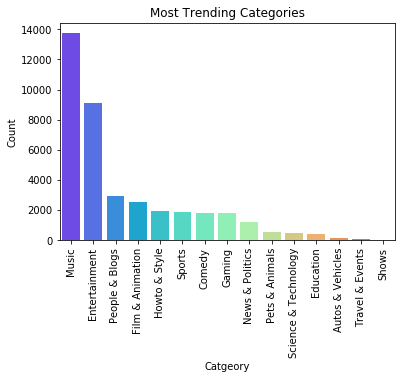

In [22]:
ax = sns.countplot(ca_videos["category_name"], palette = "rainbow",
                   order= ca_videos['category_name'].value_counts().index)
ax.set(xlabel = "Catgeory", ylabel = "Count")
plt.xticks(rotation = 90)
ax.set(title = "Most Trending Categories")


### Title Length

In [23]:
ca_videos['title_length'] = ca_videos.title.apply(lambda x: len(x))
ca_videos['title_length'].describe(percentiles=[.15,.30,.5,.65,.80, .95])

count    38847.000000
mean        49.545396
std         19.864898
min          6.000000
15%         29.000000
30%         36.000000
50%         48.000000
65%         56.000000
80%         67.000000
95%         87.000000
max        100.000000
Name: title_length, dtype: float64

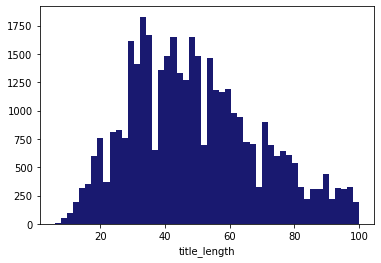

In [24]:
ax = sns.distplot(ca_videos.title_length, kde = False, color = 'midnightblue',
                  hist_kws = {'alpha': 1})

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

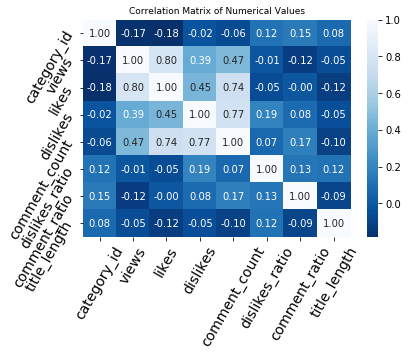

In [25]:
sns.heatmap(ca_videos.select_dtypes(include = ['number']).corr(method = 'pearson'), fmt='0.2f', cmap = 'Blues_r', annot=True)
plt.title('Correlation Matrix of Numerical Values', fontsize=9)

plt.yticks(fontsize=14, rotation=60)
plt.xticks(fontsize=14, rotation = 60)